# Time Series Analysis on Warner Bros Discovery Stock Price  

This is my first project with time series.

Notebook based on the Kaggle "Time Series" lessons: https://www.kaggle.com/learn/time-series

Dataset: https://finance.yahoo.com/quote/WBD/history?p=WBD  

Period: January 07 2022 - January 07 2023

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (15, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

import warnings
warnings.simplefilter(action='ignore')

In [2]:
import yfinance as yf
stock_symbol = 'WBD' ##change to any ticker of your choice
warner = yf.download(tickers = stock_symbol,period ='1y',interval ='1d')

[*********************100%***********************]  1 of 1 completed


# Importing Dataset

In [3]:
# warner = pd.read_csv('./warner_bros.csv', parse_dates=['Date'], index_col='Date').drop(
#     columns=['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns={'Close':'Closing Price'})

# warner.info()

In [4]:
warner.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)

In [5]:
warner.rename(columns={'Close':'Closing Price'})

,Closing Price
Date,
2022-01-10,28.590000
2022-01-11,28.680000
2022-01-12,28.790001
2022-01-13,29.340000
2022-01-14,31.180000
...,...
2023-01-03,9.540000
2023-01-04,10.380000
2023-01-05,10.860000


In [6]:
warner.index

DatetimeIndex(['2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
               '2022-01-14', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-24',
               ...
               '2022-12-23', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-09'],
              dtype='datetime64[ns]', name='Date', length=251, freq=None)

# Plotting the Data

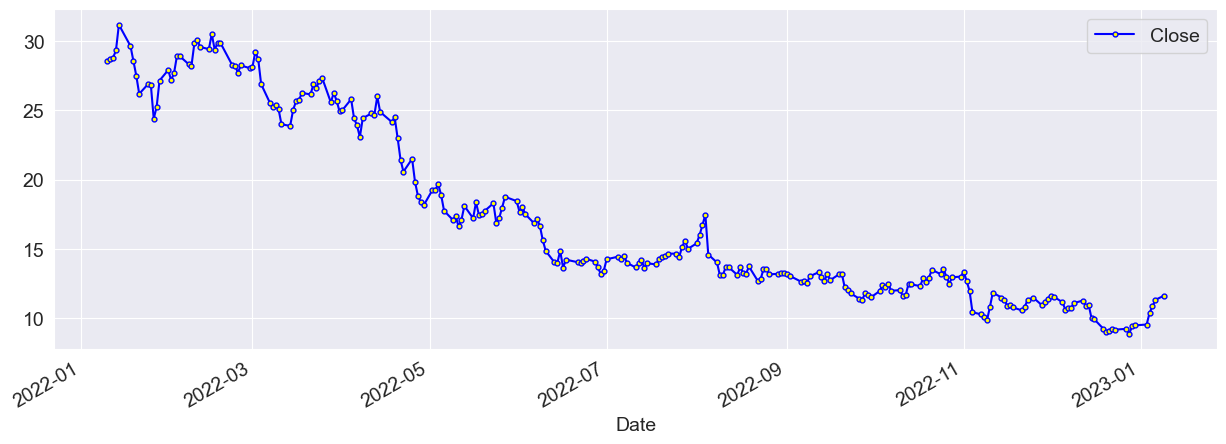

In [7]:
warner.plot(color='blue', marker='o', markersize=3.5, markerfacecolor='yellow');

# Trend  

Discovering the trend.

## Moving Average Plot Computation  

It does not seem to be a particular seasonality in the stocks' closing price.  
So, some different moving averages will be plotted to choose the smoothest one.  

Source: https://mins.space/blog/2020-06-29-moving-average-effect-window-size/

Creating a moving average function.

In [14]:
def moving_plotter(size, ax):
    # Creating the Moving Average
    mov_av = warner.rolling(
        window=size,
        center=True,
        min_periods=round(size/2)
    ).mean()
    mov_av['Trend'] = mov_av['Closing Price']
    mov_av.drop(columns='Closing Price', inplace=True)
    
    # Plotting it
    warner.plot(marker='o', color='grey', ax=ax)
    mov_av.plot(color='red', ax=ax);

Plotting different values.

KeyError: 'Closing Price'

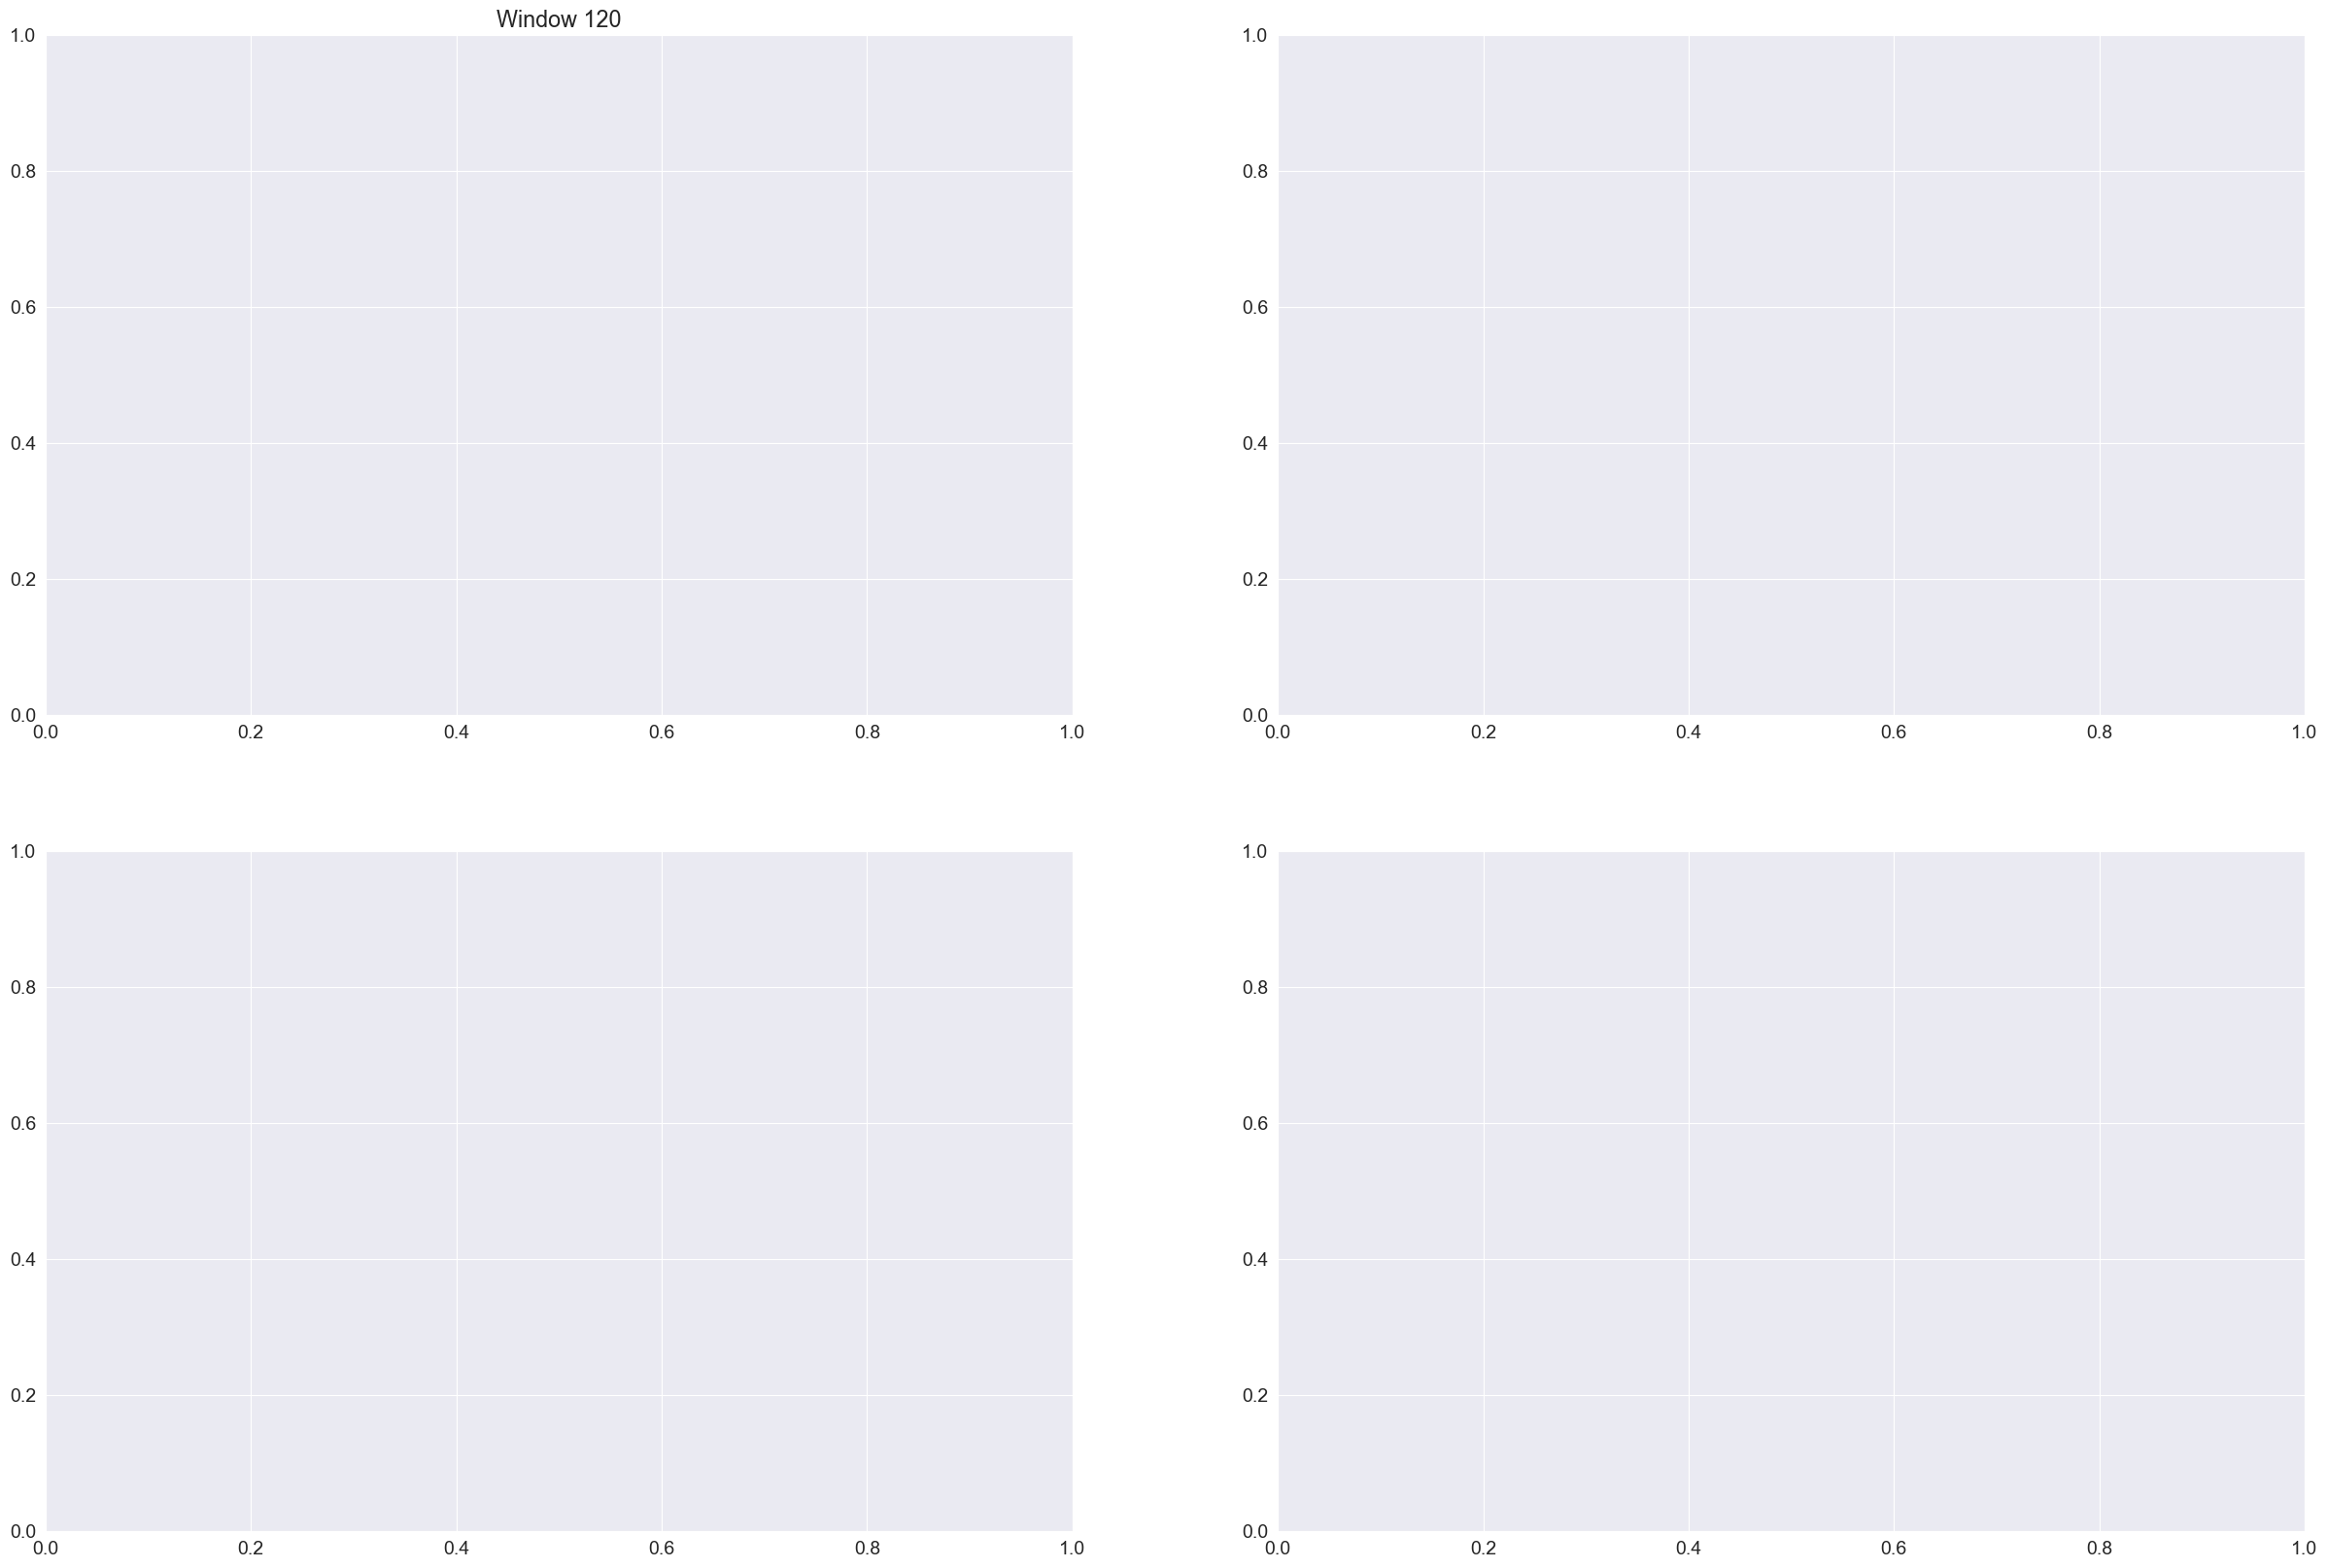

In [15]:
fig, axes = plt.subplots(2,2, figsize=(30,20))

axes[0,0].set_title('Window 120')
moving_plotter(120, axes[0,0])

axes[1,0].set_title('Window 150')
moving_plotter(150, ax=axes[1,0])

axes[0,1].set_title('Window 200')
moving_plotter(200, ax=axes[0,1])

axes[1,1].set_title('Window 250')
moving_plotter(250, ax=axes[1,1])

A 120 window seems to fit the trend well.

## Deterministic Process  

It will be used to make predictions about the trend and trying some forecasts.

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=warner.index,
    constant=True,
    order=2,
    drop=True
)

X = dp.in_sample()

In [ ]:
X

In [ ]:
y = warner['Closing Price']

from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), columns=['Trend'], index=X.index)

In [ ]:
y_pred

In [ ]:
y

Plotting the results.

In [ ]:
fig, ax = plt.subplots()

y.plot(color='grey', ax=ax)

y_pred.plot(color='blue', ax=ax);

Making forecasts.

In [ ]:
X_fore = dp.out_of_sample(steps=30)
y_fore = pd.DataFrame(model.predict(X_fore), columns=['Forecasts'])

y_fore.index = pd.date_range(start='2023-01-07', periods=30)
y_fore.head()

Plotting actual values, trend and forecasted trend.

In [ ]:
fig, ax = plt.subplots()

# Actual Values
warner.plot(color='grey', marker='o', ax=ax)

# Trend
y_pred.plot(color='blue', ax=ax)

# Forecasts
y_fore.plot(color='red', ax=ax);

# Hybrid Models Usage  

Firstly, series will be detrended (using LinearRegression()); then the XGBRegressor will be used on the residuals.

Splitting the X and the y on the month basis.
Data until 24-10-2022 will be included in the training set, others will be part of the test set.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Checking the sets.

In [ ]:
X_train

In [ ]:
X_test.head()

In [ ]:
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

In [ ]:
y_train

In [ ]:
y_test.head()

Model creation.

In [ ]:
# Creating the Model
lin_model = LinearRegression(fit_intercept=False)
lin_model.fit(X_train, y_train)

# Storing the Predictions (y_pred --> training set; y_fore --> test set)
y_pred = pd.DataFrame(lin_model.predict(X_train), columns=['Predictions'], index=X_train.index)
y_fore = pd.DataFrame(lin_model.predict(X_test), columns=['Forecasts'], index=X_test.index)

Plotting the results.

In [ ]:
# Actual Values
sns.lineplot(data=warner, x=warner.index, y='Closing Price', color='grey', marker='o')

# Predictions
sns.lineplot(data=y_pred, x=y_pred.index, y='Predictions', color='blue')

# Forecasts
sns.lineplot(data=y_fore, x=y_fore.index, y='Forecasts', color='red')
plt.legend(['Actual Values', 'Predictions', 'Forecasts']);

Second part using XGBRegressor.  

Firstly, some features must be created.

In [ ]:
warner['Year'] = pd.to_datetime(warner.index).year
warner['Month'] = pd.to_datetime(warner.index).month
warner['DayOfWeek'] = pd.to_datetime(warner.index).dayofweek

warner

Defining X and y.

In [ ]:
X = warner.drop(columns='Closing Price')
y = warner['Closing Price']

In [ ]:
X.head()

In [ ]:
y.head()

Splitting.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

In [ ]:
X_train

In [ ]:
X_test.head()

In [ ]:
y_train

In [ ]:
y_test.head()

Creating the residuals.

In [ ]:
y_resid = y_train - y_pred.squeeze()
y_resid

Creating the model to fit with the residuals.

In [ ]:
from xgboost import XGBRegressor

# Creating the Model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_resid)

# Adding the predicted residuals to the trend
y_pred_xgb = xgb_model.predict(X_train) + y_pred.squeeze()
y_fore_xgb = xgb_model.predict(X_test) + y_fore.squeeze()

In [ ]:
y_pred_xgb

In [ ]:
y_fore_xgb.head()

Plotting the results.

In [ ]:
# Actual Values
sns.lineplot(data=warner, x=warner.index, y='Closing Price', marker='o', color='grey')

# Predictions
sns.lineplot(data=y_pred_xgb, x=y_pred_xgb.index, y=y_pred_xgb.values, color='blue')

# Forecasts
sns.lineplot(data=y_fore_xgb, x=y_fore_xgb.index, y=y_fore_xgb.values, color='red');

# Forecasts  

It will be performed some forecasts on a 4-day horizon with 1-day lead time. 

Creation of the lags.

In [ ]:
warner.drop(columns=['Year', 'Month', 'DayOfWeek'], inplace=True)
warner

In [ ]:
def lag_creation(period):
    new_col = warner['Closing Price'].shift(period)
    warner['Lag_{}'.format(period)] = new_col

In [ ]:
[lag_creation(period) for period in range(1,5)]
warner

In [ ]:
warner.fillna(0, inplace=True)
warner

Creating the X.

In [ ]:
X = warner.drop(columns='Closing Price')
X

Creating 4 steps.

In [ ]:
def step_creator(step):
    new_col = warner['Closing Price'].shift(-step)
    warner['Step_{}'.format(step)] = new_col

In [ ]:
[step_creator(step) for step in range(4)]
warner

Step_0 and Closing Price are the same.

Choosing the y.

In [ ]:
y = warner.drop(columns=warner.columns[:5])
y.dropna(inplace=True)
y

Since X and y have different shapes, only the periods in both dataset will be selected.

In [ ]:
final_df = pd.concat([y,X], axis=1).dropna()
final_df

Creating the new X and the new y.

In [ ]:
X = final_df.drop(columns=final_df.columns[:4])
y = final_df.drop(columns=final_df.columns[4:])

In [ ]:
X

In [ ]:
y

## MultiOutput Strategy  

It will be used the LinearRegression() algorithm.

In [ ]:
# Splitting X and y
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

# Creating the Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Storing the Results
y_pred = pd.DataFrame(linear_model.predict(X_train), index=y_train.index, columns=y.columns)
y_fore = pd.DataFrame(linear_model.predict(X_test), index=y_test.index, columns=y.columns)

In [ ]:
y_pred

In [ ]:
y_train

In [ ]:
y_fore.head()

Plotting the results.

In [ ]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_pred.index].plot(color='grey', marker='o')

# y_pred
y_pred.plot(ax=ax);

In [ ]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_fore.index].plot(color='grey', marker='o')

# y_pred
y_fore.plot(ax=ax);

Checking the RMSE.

In [ ]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_train, y_pred, squared=False))
print(mean_squared_error(y_test, y_fore, squared=False))

The RMSE is quite good. The biggest mistake was done on the first observation.

## Direct Strategy  

Direct Strategy with XGBRegressor.

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

xgb_multi = MultiOutputRegressor(XGBRegressor())
xgb_multi.fit(X_train, y_train)

y_pred = pd.DataFrame(xgb_multi.predict(X_train), index=X_train.index, columns=y.columns)
y_fore = pd.DataFrame(xgb_multi.predict(X_test), index=X_test.index, columns=y.columns)

Plotting the results.

In [ ]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_pred.index].plot(color='grey', marker='o', ax=ax)

# Predictions
y_pred.plot(ax=ax);


In [ ]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_fore.index].plot(color='grey', marker='o', ax=ax)

# Forecasts
y_fore.plot(ax=ax);

It seems to show overfitting.

In [ ]:
print(mean_squared_error(y_train, y_pred, squared=False))
print(mean_squared_error(y_test, y_fore, squared=False))